In [1]:
import os
import pandas as pd
from deepface import DeepFace
import numpy as np

# Dataset directories
base_dir = "fer2013_original"
subdirs = ["train", "val", "test"]

# Prepare a list for image metadata
image_data = []

for subdir in subdirs:
    subdir_path = os.path.join(base_dir, subdir)
    for img_name in os.listdir(subdir_path):
        emotion = img_name.split("_")[2].split(".")[0]
        img_path = os.path.join(subdir_path, img_name)
        image_data.append({"path": img_path, "emotion": emotion, "usage": subdir})

df = pd.DataFrame(image_data)
embeddings = []
labels = []
usages = []

for idx, row in df.iterrows():
    try:
        embedding = DeepFace.represent(img_path=row['path'], detector_backend ="retinaface", align=True)
        embeddings.append(embedding[0]['embedding'])
        labels.append(row['emotion'])
        usages.append(row['usage'])
    except Exception as e:
        print(f"Error processing {row['path']}: {e}")

# Save as CSV
output_data = pd.DataFrame(embeddings)
output_data['emotion'] = labels
output_data['usage'] = usages
output_data.to_csv("fer2013_embeddings.csv", index=False)

2024-12-09 16:33:20.362674: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 16:33:20.509021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733754800.566240     580 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733754800.583341     580 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 16:33:20.718198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

24-12-09 16:33:23 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /home/alex/.deepface/weights/vgg_face_weights.h5
100%|██████████████████████████████████████████████████████████████████████| 580M/580M [00:06<00:00, 94.7MB/s]
I0000 00:00:1733754813.285388     774 cuda_dnn.cc:529] Loaded cuDNN version 90300


Error processing fer2013_original/train/train_1716_angry.jpg: Face could not be detected in fer2013_original/train/train_1716_angry.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing fer2013_original/train/train_2007_fear.jpg: Face could not be detected in fer2013_original/train/train_2007_fear.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing fer2013_original/train/train_145_angry.jpg: Face could not be detected in fer2013_original/train/train_145_angry.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing fer2013_original/train/train_3190_sad.jpg: Face could not be detected in fer2013_original/train/train_3190_sad.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing fer2013_original/train/train_16_surprise.jp

/home/alex/TensorProjects/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:25:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.87683	validation_0-merror:0.54246
[1]	validation_0-mlogloss:1.81977	validation_0-merror:0.52619
[2]	validation_0-mlogloss:1.77388	validation_0-merror:0.52226
[3]	validation_0-mlogloss:1.73176	validation_0-merror:0.51478
[4]	validation_0-mlogloss:1.69549	validation_0-merror:0.50879
[5]	validation_0-mlogloss:1.66239	validation_0-merror:0.50374
[6]	validation_0-mlogloss:1.63224	validation_0-merror:0.49495
[7]	validation_0-mlogloss:1.60467	validation_0-merror:0.49327
[8]	validation_0-mlogloss:1.58037	validation_0-merror:0.48934
[9]	validation_0-mlogloss:1.55702	validation_0-merror:0.48616
[10]	validation_0-mlogloss:1.53625	validation_0-merror:0.48279
[11]	validation_0-mlogloss:1.51680	validation_0-merror:0.48223
[12]	validation_0-mlogloss:1.49890	validation_0-merror:0.47849
[13]	validation_0-mlogloss:1.48184	validation_0-merror:0.47793
[14]	validation_0-mlogloss:1.46556	validation_0-merror:0.47325
[15]	validation_0-mlogloss:1.45083	validation_0-merror:0.47344
[1

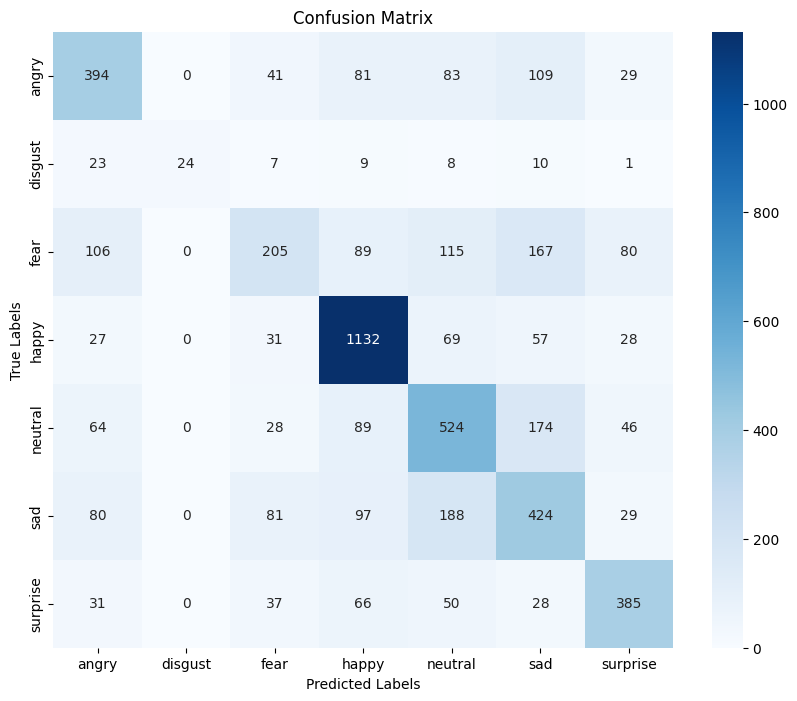

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the embeddings
data = pd.read_csv("fer2013_embeddings.csv")
X = data.iloc[:, :-2].values  # Features
y = data['emotion'].values  # Labels

# Encode the labels into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Train a gradient boosting classifier
clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric=["mlogloss", "merror"],
    use_label_encoder=False,
)

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=1,
)

# Evaluate on the test set
y_pred = clf.predict(X_test)

# Decode predicted labels back to original emotions
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

print(classification_report(y_test_decoded, y_pred_decoded))

# Plot a confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [2]:
clf.save_model("xgboost_emotion_model.json")

In [3]:
from xgboost import XGBClassifier

# Load the model from the file
loaded_model = XGBClassifier()
loaded_model.load_model("xgboost_emotion_model.json")

print("Model loaded successfully")

Model loaded successfully


In [6]:
from deepface import DeepFace
import numpy as np

# Path to the new image
new_image_path = "fer_plus_balanced/test/test_2_sad.png"

# Extract the embedding for the new image
embedding = DeepFace.represent(img_path=new_image_path, detector_backend="retinaface", align=True)
embedding_vector = np.array(embedding[0]['embedding']).reshape(1, -1)  # Reshape for prediction

# Predict the emotion
predicted_label_numeric = loaded_model.predict(embedding_vector)
predicted_label = label_encoder.inverse_transform(predicted_label_numeric)

print(f"Predicted emotion: {predicted_label[0]}")

Predicted emotion: sad


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResEmoteNetForEmbeddings(nn.Module):
    def __init__(self, input_size=512, num_classes=7):
        """
        Model adapted for embeddings.
        Parameters:
            input_size (int): Size of the embedding vector.
            num_classes (int): Number of output classes.
        """
        super(ResEmoteNetForEmbeddings, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = self.fc4(x)
        return x


ModuleNotFoundError: No module named 'torch'